In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import fitsio

In [4]:
#Datos ordenados segun TARGETID. 
data_tru = fitsio.read('/home/sd.lobo251/Documents/dc17b/data_true_mod.fits') 
data_tar = fitsio.read('/home/sd.lobo251/Documents/dc17b/data_tar_mod.fits')

In [5]:
print('Field names in data_tru: \n')
for name in data_tru.dtype.names:
    print('{:16}'.format(name))

Field names in data_tru: 

TARGETID        
MOCKID          
CONTAM_TARGET   
TRUEZ           
TRUESPECTYPE    
TEMPLATETYPE    
TEMPLATESUBTYPE 
TEMPLATEID      
SEED            
MAG             
FLUX_G          
FLUX_R          
FLUX_Z          
FLUX_W1         
FLUX_W2         
OIIFLUX         
HBETAFLUX       
TEFF            
LOGG            
FEH             


In [6]:
print('Field names in data_tar: \n')
for name in data_tar.dtype.names:
    print('{:16}'.format(name))

Field names in data_tar: 

TARGETID        
BRICKNAME       
BRICK_OBJID     
RA              
DEC             
FLUX_G          
FLUX_R          
FLUX_Z          
FLUX_W1         
FLUX_W2         
SHAPEEXP_R      
SHAPEEXP_E1     
SHAPEEXP_E2     
SHAPEDEV_R      
SHAPEDEV_E1     
SHAPEDEV_E2     
PSFDEPTH_G      
PSFDEPTH_R      
PSFDEPTH_Z      
GALDEPTH_G      
GALDEPTH_R      
GALDEPTH_Z      
MW_TRANSMISSION_G
MW_TRANSMISSION_R
MW_TRANSMISSION_Z
MW_TRANSMISSION_W1
MW_TRANSMISSION_W2
BRICKID         
DESI_TARGET     
BGS_TARGET      
MWS_TARGET      
HPXPIXEL        
SUBPRIORITY     
OBSCONDITIONS   
CHI2            
COEFF           
Z               
ZERR            
ZWARN           
SPECTYPE        
SUBTYPE         
DELTACHI2       


In [7]:
# Arreglos con los datos de REDSHIFT TRUE y TARGET
true_Z= data_tru['TRUEZ']
tar_Z = data_tar['Z']

print('Len true_Z : {}\nLen tar_Z : {}'.format(len(true_Z), len(tar_Z)))

Len true_Z : 2131896
Len tar_Z : 2131896


Text(0,0.5,'Target Z')

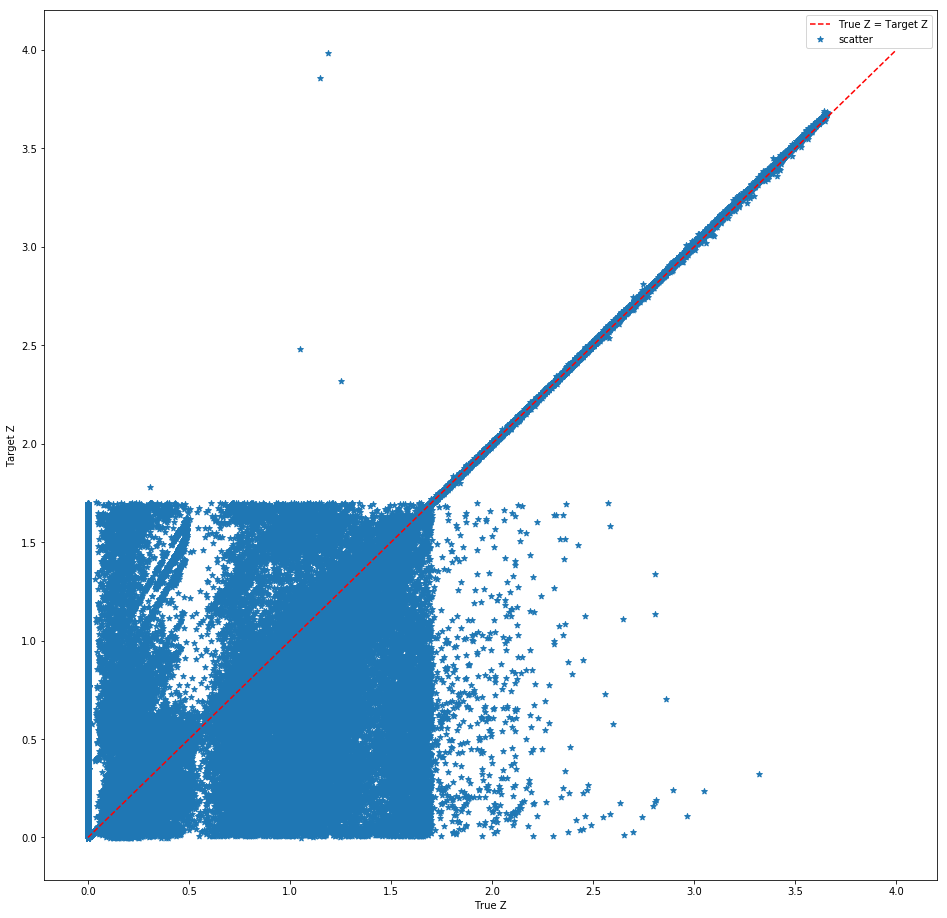

In [43]:
#Relacion entre TARGET Z y TRUE Z. 
x_f = linspace(0, 4.0, 100)

fig, ax = subplots(figsize=(16, 16))
ax.plot(x_f, x_f, '--', color='r')
ax.scatter(true_Z, tar_Z, marker='*')
ax.legend(('True Z = Target Z', 'scatter'))
ax.set_xlabel('True Z')
ax.set_ylabel('Target Z')

In [9]:
#estadísticas de TRUE_Z y MAGNITUDE
from scipy import stats
magnitude = data_tru['MAG']
print(stats.describe(abs(true_Z)))
print(stats.describe(magnitude))


DescribeResult(nobs=2131896, minmax=(0.0, 3.658788), mean=0.63839346, variance=0.27866265, skewness=1.3331096172332764, kurtosis=2.96725636522575)
DescribeResult(nobs=2131896, minmax=(2.19822, 25.0261), mean=20.1918, variance=3.29643, skewness=-0.29287204146385193, kurtosis=0.7103611336198803)


# Nueva tabla con Id, mag, TrueZ y Z para ordenarla y hacer el histograma. 

In [10]:
# Probando una forma diferente de abrir el archivo para reordenarlo
fits_tru = fitsio.FITS('/home/sd.lobo251/Documents/dc17b/data_true_mod.fits')
# Se aisla las columnas de TARGETID, MAG y TRUEZ en un nuevo archivo
tru_mag_with_id = fits_tru[1]['TARGETID', 'MAG', 'TRUEZ'][:]

In [11]:
# Igual que la celda de arriba pero para los datos tARGET
fits_tar = fitsio.FITS('/home/sd.lobo251/Documents/dc17b/data_tar_mod.fits')
tar_z = fits_tar[1]['Z'][:]

In [12]:
#Creamos un solo archivo uniendo tru_mag_with_id y tar_z
from numpy.lib.recfunctions import append_fields

magnitudes_Z = append_fields(tru_mag_with_id, 'Z', tar_z, usemask=False)

In [13]:
# Ordenamos la tabla FITS 'magnitudes_Z' según la columna de MAGNITUD
magnitudes_Z.sort(order='MAG')

In [14]:
magnitudes_Z[0]

(288230408724718789, -1.5473704e-05, 2.19822, -1.40404791e-05)

In [15]:
# Se calucla el error entre el TRUE_Z y el TARGET_Z y se clasifica segun sea menor al 1%, al 5%, al 10%, o mayor.
# si el error es menor a cierto valor, se cuenta como un 1 en el respectivo valor. 

#arreglo para guardar los resultados de la evaluación de error.
count = zeros((len(magnitudes_Z)), dtype=[('10%', 'int32'), ('5%', 'int32'), ('1%', 'int32')])
for i, line in enumerate(magnitudes_Z):
    truez = line[1]
    tarz  = line[3]
    if truez != 0: error = abs(truez - tarz)/abs(truez)
    else : error = abs(truez - tarz)
    if error < 0.1:
        count['10%'][i] = 1
        if error < 0.05:
            count['5%'][i] = 1
            if error < 0.01:
                count['1%'][i] = 1


In [16]:
from numpy.lib.recfunctions import merge_arrays
# Ahora unimos a la tabla de 'magnitud_Z, las columnas que indican en cuál rango de error se encuenta la diferencian entre
# TRUEZ y TARZ
datos_histograma = merge_arrays((magnitudes_Z, count), asrecarray=True, flatten=True)

In [17]:
datos_histograma[0:10]

rec.array([(288230408724718789, -1.5473704e-05, 2.19822, -1.40404791e-05, 1, 0, 0),
           (288230402005409031,  7.7594012e-07, 3.34669,  1.40525757e-06, 0, 0, 0),
           (288230426516919074, -1.4716615e-05, 3.87593, -1.31871519e-05, 0, 0, 0),
           (288230408863094438, -2.5252002e-05, 4.27218, -2.40412523e-05, 1, 1, 0),
           (288230494879910126,  8.9394511e-05, 4.44423,  9.02894620e-05, 1, 1, 0),
           (288230494867327216, -1.6491676e-05, 4.65242, -1.30584209e-05, 0, 0, 0),
           (288230402022186515,  3.9586386e-05, 4.69957,  4.02120011e-05, 1, 1, 0),
           (288230394384356812,  8.5539512e-05, 4.8079 ,  8.81612058e-05, 1, 1, 0),
           (288230404555569089,  9.1908580e-05, 4.89583,  9.73034908e-05, 1, 0, 0),
           (288230376713768290,  3.5755071e-05, 4.93649,  3.60923326e-05, 1, 1, 1)],
          dtype=[('TARGETID', '>i8'), ('TRUEZ', '>f4'), ('MAG', '>f4'), ('Z', '>f8'), ('10%', '<i4'), ('5%', '<i4'), ('1%', '<i4')])

In [18]:
#funcion para crear las listas que después serán graficadas.
def generate_hist(n_bins, min_value, max_value, datos):
    
    ran = (max_value - min_value)/n_bins
    his_1 = zeros(n_bins)
    his_5 = zeros(n_bins)
    his_10 = zeros(n_bins)
    
    tot_his = zeros(n_bins)

    start = min_value #*( 1 - sign(min_value)/100)
    j = 0
    
    #Se recorren los datos y se le suma a hist_1, hist_5 o hist_10 según sea el error. 
    for i in range(n_bins):
        
        if i == n_bins - 1:
            start += start/100
        while datos['MAG'][j] < start + ran :
            tot_his[i] += 1
            if datos['10%'][j] == 1:
                his_10[i] += 1
                if datos['5%'][j] == 1:
                    his_5[i] += 1
                    if datos['1%'][j] == 1:
                        his_1[i] += 1
            j += 1
            if j == len(datos):
                break
            
        start += ran
    
    print(j)
    return tot_his, his_1, his_5, his_10    
        
        
        
    
    

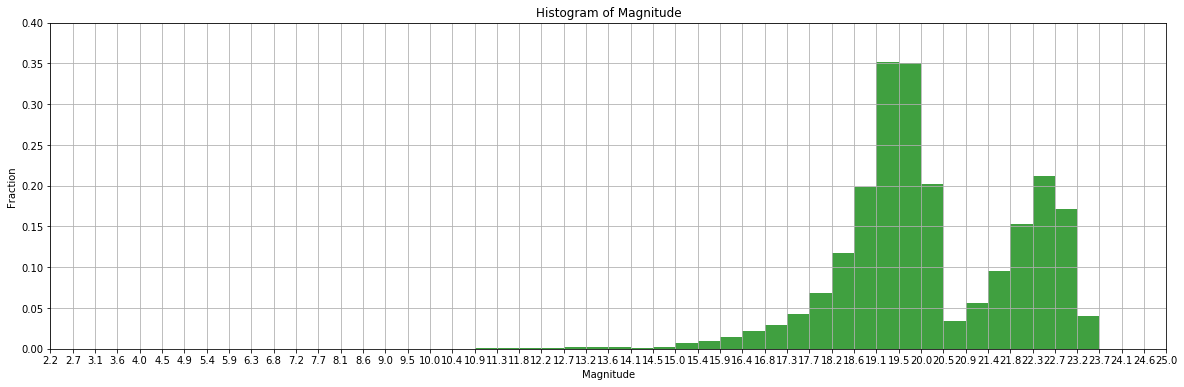

In [24]:
figure(figsize=(20,6))
n, bins, patches = plt.hist(magnitude, 50, (min(magnitude), max(magnitude)), density=True, facecolor='g', alpha=0.75)
plt.xlabel('Magnitude')
plt.ylabel('Fraction')
plt.title('Histogram of Magnitude')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([min(magnitude), max(magnitude), 0, 0.40])
plt.xticks(bins, [round(i, 1) for i in bins])
plt.grid(True)

In [25]:
mi = min(datos_histograma['MAG'])
ma = max(datos_histograma['MAG'])
n_bins = 50
tot_his, his_1, his_5, his_10 = generate_hist(n_bins, mi, ma, datos_histograma)

2131896


In [358]:
print('{} {} {} {}'. format(len(tot_his), len(his_1), len(his_5), len(his_10)))

50 50 50 50


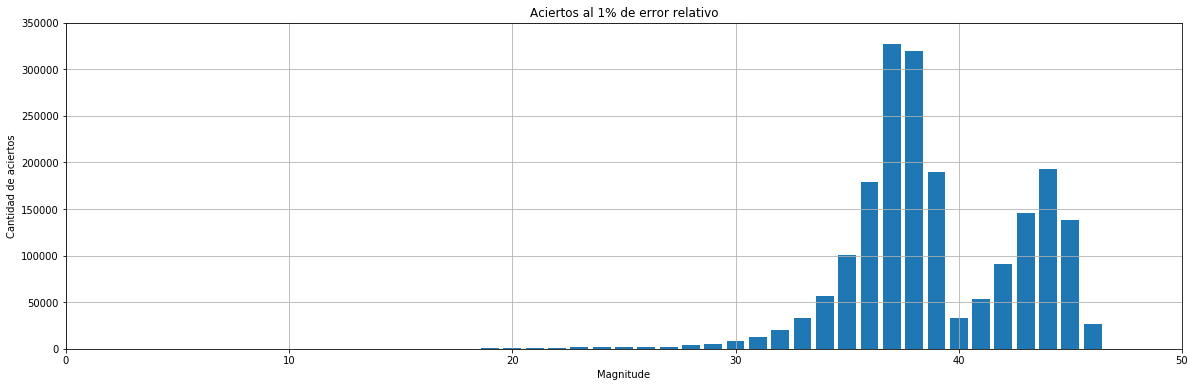

In [47]:
figure(figsize=(20,6))
bar(arange(50),his_1)
plt.xlabel('Magnitude')
plt.ylabel('Cantidad de aciertos')
plt.title('Aciertos al 1% de error relativo')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([0, 50, 0, 350000])
#plt.xticks(bins, [round(i, 1) for i in bins])
plt.grid(True)

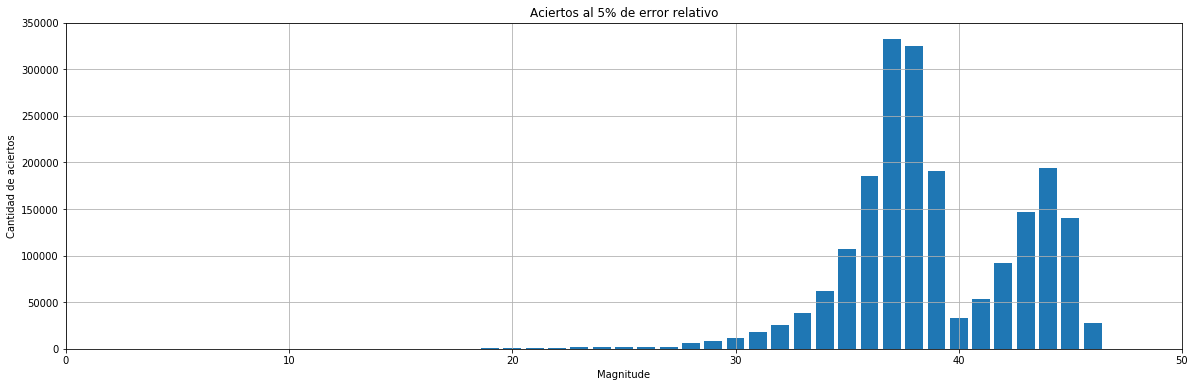

In [46]:
figure(figsize=(20,6))
bar(arange(50),his_5)
plt.xlabel('Magnitude')
plt.ylabel('Cantidad de aciertos')
plt.title('Aciertos al 5% de error relativo')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([0, 50, 0, 350000])
#plt.xticks(bins, [round(i, 1) for i in bins])
plt.grid(True)

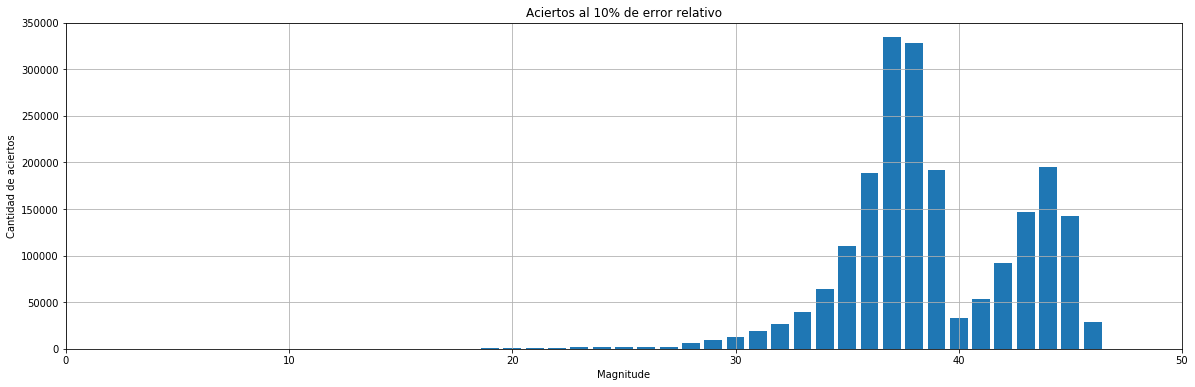

In [45]:
figure(figsize=(20,6))
bar(arange(50),his_10)
plt.xlabel('Magnitude')
plt.ylabel('Cantidad de aciertos')
plt.title('Aciertos al 10% de error relativo')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([0, 50, 0, 350000])
#plt.xticks(bins, [round(i, 1) for i in bins])
plt.grid(True)

In [320]:
his_10

array([   1.,    0.,    4.,    5.,    6.,    6.,   20.,   77.,  217.,  614.])

# Distribución de aciertos por cada intervalo de magnitud:

In [30]:
# se normaliza cada bin segun el numero total de mediciones en cada uno
final_his_1 = zeros(n_bins)
for i in range(n_bins):
    if tot_his[i] != 0:
        final_his_1[i] = his_1[i]/tot_his[i]

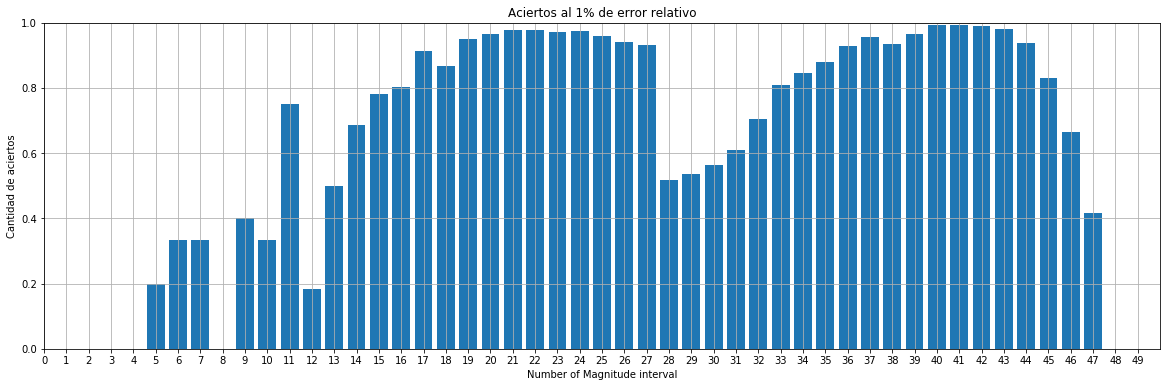

In [48]:
figure(figsize=(20,6))
bar(arange(50),final_his_1)
plt.xlabel('Number of Magnitude interval')
plt.ylabel('Cantidad de aciertos')
plt.title('Aciertos al 1% de error relativo')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([0, 50, 0, 1.0])
plt.xticks(arange(0, n_bins ))
plt.grid(True)

In [37]:
final_his_5 = zeros(n_bins)
for i in range(n_bins):
    if tot_his[i] != 0:
        final_his_5[i] = his_5[i]/tot_his[i]


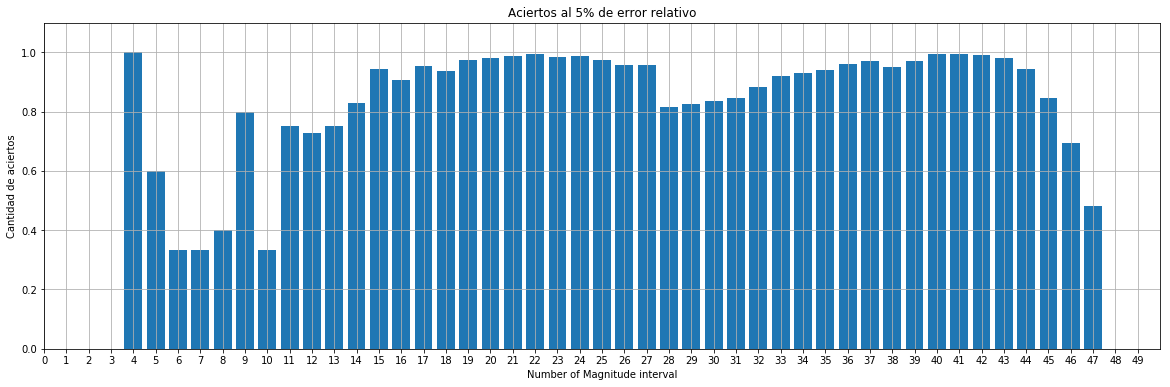

In [49]:
figure(figsize=(20,6))
bar(arange(50),final_his_5)
plt.xlabel('Number of Magnitude interval')
plt.ylabel('Cantidad de aciertos')
plt.title('Aciertos al 5% de error relativo')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([0, 50, 0, 1.1])
plt.xticks(arange(0, n_bins ))
plt.grid(True)

In [40]:
final_his_10 = zeros(n_bins)
for i in range(n_bins):
    if tot_his[i] != 0:
        final_his_10[i] = his_10[i]/tot_his[i]


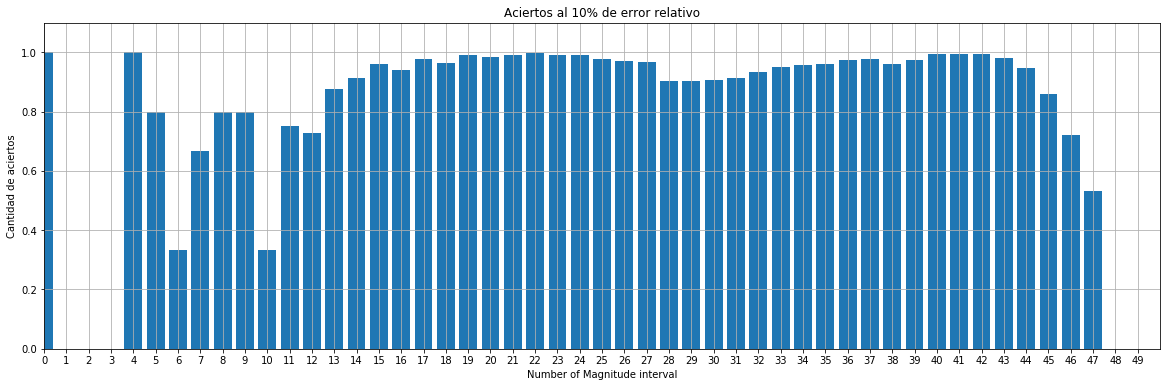

In [50]:
figure(figsize=(20,6))
bar(arange(50),final_his_10)
plt.xlabel('Number of Magnitude interval')
plt.ylabel('Cantidad de aciertos')
plt.title('Aciertos al 10% de error relativo')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([0, 50, 0, 1.1])
plt.xticks(arange(0, n_bins ))
plt.grid(True)